In [16]:
from nltk.tokenize import sent_tokenize

import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances


from reco_systems.filter import filter_df
from reco_systems.llm import *
from reco_systems.CF_knn import *
from reco_systems.user_game_matrix import *
from reco_systems.evaluation import *
from reco_systems.text_filtering import *

from sklearn.feature_extraction.text import CountVectorizer
from treetaggerwrapper import TreeTagger
from nltk.corpus import stopwords
from nltk import word_tokenize
import textwrap
from string import punctuation
from unicodedata import normalize
from unidecode import unidecode


sns.set_theme()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv")
corpus = construction_corpus(lemmas, 5000)
lemmas = lemmas[lemmas["Lemma"].isin(corpus)]

comments_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index()
rev_filter = rev_filter[rev_filter["index"].isin(comments_lemmatized["Comment line"])]
comments_lemmatized = comments_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index")

rev_filter, _ = center_score(rev_filter)
users_means = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


### Sentence splitting

In [ ]:
# rev_filter_embed = rev_filter.copy()

# # Unicode normalization
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].apply(lambda row : normalize("NFKC", row))

# # Replace extra caracters that served as a separation
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\*{15,}", " ", regex=True)
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"-{10,}", " ", regex=True)

# # Add space after . or ? or ! for phrases 
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r'([.!?\)])(?=\S)', r'\1 ', regex=True)

# # replace /' by '
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\\{1,}'", r"'", regex=True)

# # Delete *** (more that 7 times) 
# rev_filter_embed["Phrases"] = rev_filter_embed["Comment body"].apply(sent_tokenize)
# rev_filter_embed = rev_filter_embed[["Game id", "User id", "index", "Phrases"]]
# rev_filter_embed = rev_filter_embed.explode("Phrases")

# # Delete phrases that contains only regex
# punc_regex = r"^[^\w\s]+$"
# rev_filter_embed = rev_filter_embed[~rev_filter_embed["Phrases"].str.match(punc_regex, na=False)]
# rev_filter_embed["Length"] = rev_filter_embed["Phrases"].str.split().apply(len)
# rev_filter_embed["Length"].sort_values().tail(10)
# rev_filter_embed.shape

(620763, 5)

### Embeddings

In [ ]:
# # Embed separately 
# long_row = rev_filter_embed[rev_filter_embed["Length"] > 700]
# rev_filter_embed = rev_filter_embed.drop(long_row.index)

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# phrases = rev_filter_embed["Phrases"].tolist()

# Time spent : 10h37min
# # Batch encode
# encoded = model.encode(phrases, batch_size=16, max_length=800, return_dense=True)

# encoded_long = model.encode(long_row["Phrases"].item(), max_length=2048, return_dense=True)

# embed = rev_filter_embed.assign(Embedding = list(encoded["dense_vecs"]))
# long_row["Embedding"] = [list(encoded_long["dense_vecs"])]
# embed = pd.concat([embed, long_row])
# # embed
# embed.to_parquet("../generated_data/comments_embed.parquet")

### KMeans clustering on all comments (no pos/neg separation)

In [6]:
comments_embed = pd.read_parquet("../generated_data/comments_embed.parquet")
comments_embed = comments_embed[comments_embed["Phrases"].str.contains(r'[a-zA-Z]', regex=True)]

In [7]:
embeds = np.array(comments_embed["Embedding"].tolist())
embeds.shape

(611907, 1024)

In [ ]:
distortions_means = []
centroids_distances = []
nb_clusters = np.arange(100, 1100, 100)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=1) 
    kmeans.fit(embeds) 
    print("Clustering done")

    centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
    print(centers.shape)

    distances = np.linalg.norm(embeds - centers, axis=1)
    print("Distances calculated")

    distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)


1000
Init 1/1 with method k-means++
Inertia for init 1/1: 1817.5485652164111
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/59756: mean batch inertia: 0.5853137184625318
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 2/59756: mean batch inertia: 0.48044795411010865, ewa inertia: 0.48044795411010865
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 3/59756: mean batch inertia: 0.4475693105373687, ewa inertia: 0.4803379123031099
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 4/59756: mean batch inertia: 0.43421304532569527, ewa inertia: 0.48018353660027585
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 5/59756: mean batch inertia: 0.427532601546527, ewa inertia: 0.4800073187456472
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 6/59756: mean batch inertia: 0.42007330966833706, ewa inertia: 0.4798067251096916
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 7/59

KeyboardInterrupt: 

Text(0.5, 0.98, 'Clusters on all comments')

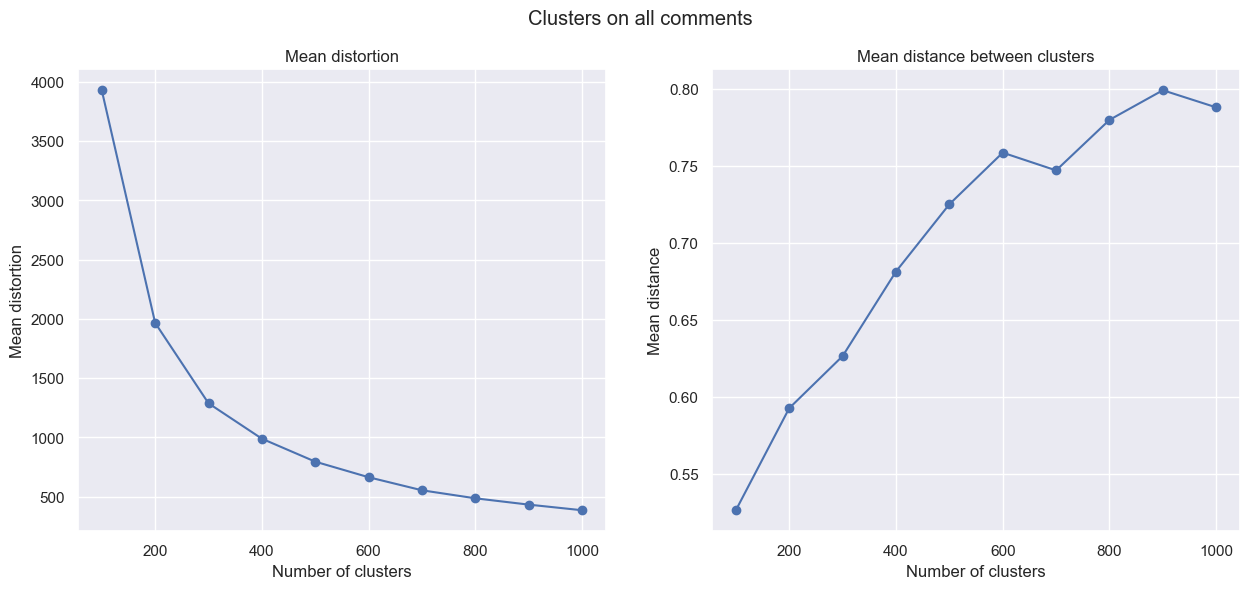

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nb_clusters, distortions_means, marker='o')
ax1.set_title("Mean distortion")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean distortion")

ax2.plot(nb_clusters, centroids_distances, marker='o')
ax2.set_title("Mean distance between clusters")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

fig.suptitle("Clusters on all comments")

### KMeans clustering (pos/neg separation)

In [11]:
rev_filter_pos = rev_filter[rev_filter["Rating"] >= 0]
rev_filter_neg = rev_filter[rev_filter["Rating"] < 0]
rev_filter_pos.shape, rev_filter_neg.shape

comments_embed_pos = comments_embed[comments_embed["index"].isin(rev_filter_pos["index"])]
comments_embed_neg = comments_embed[comments_embed["index"].isin(rev_filter_neg["index"])]
comments_embed_pos.shape, comments_embed_neg.shape

((247128, 6), (184609, 6))

#### Positive

400
Clustering done
(247128, 1024)
Distances calculated
350
Clustering done
(247128, 1024)
Distances calculated
300
Clustering done
(247128, 1024)
Distances calculated
250
Clustering done
(247128, 1024)
Distances calculated
200
Clustering done
(247128, 1024)
Distances calculated
150
Clustering done
(247128, 1024)
Distances calculated
100
Clustering done
(247128, 1024)
Distances calculated
50
Clustering done
(247128, 1024)
Distances calculated


Text(0.5, 0.98, 'Clusters on positive comments')

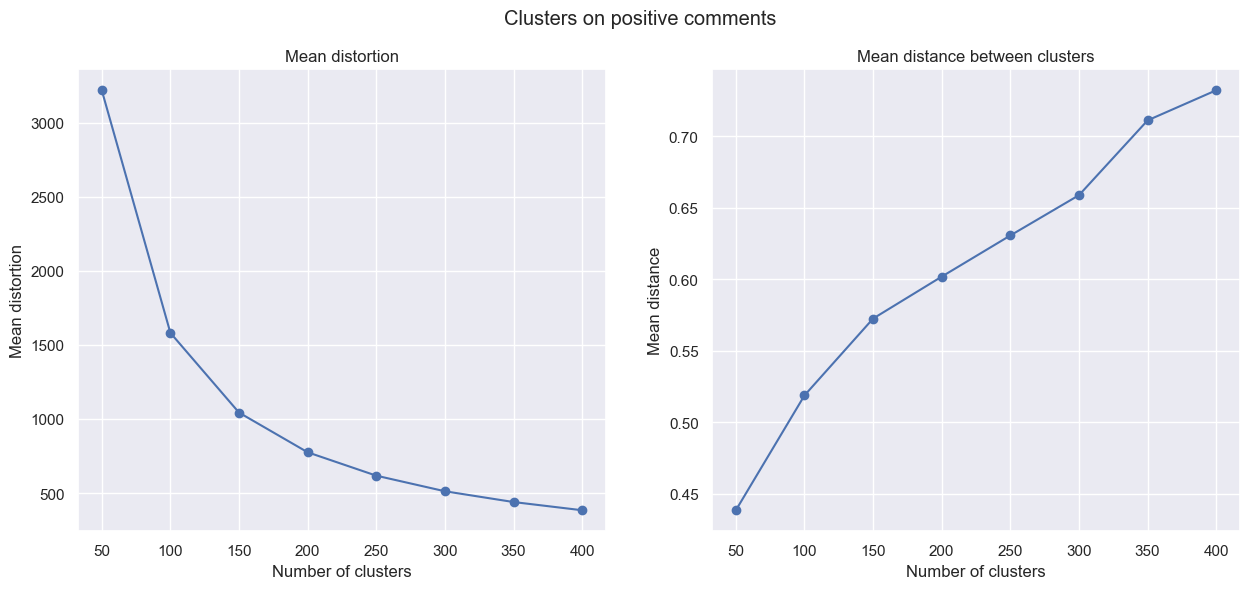

In [20]:
embeds_pos = np.array(comments_embed_pos["Embedding"].tolist())

distortions_means = []
centroids_distances = []
nb_clusters = np.arange(50, 450, 50)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
    kmeans.fit(embeds_pos) 
    print("Clustering done")

    centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
    print(centers.shape)

    distances = np.linalg.norm(embeds_pos - centers, axis=1)
    print("Distances calculated")

    distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nb_clusters, distortions_means, marker='o')
ax1.set_title("Mean distortion")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean distortion")

ax2.plot(nb_clusters, centroids_distances, marker='o')
ax2.set_title("Mean distance between clusters")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

fig.suptitle("Clusters on positive comments")

#### $200$ clusters

In [47]:
kmeans = MiniBatchKMeans(n_clusters=200, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_pos)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_pos - centers, axis=1)

pos_comments_clusters = comments_embed_pos.assign(Cluster=kmeans.labels_, Distance_centroid=distances)
pos_comments_clusters

,Game id,User id,index,Phrases,Length,Embedding,Cluster,Distance_centroid
1,6179,1,1,Comment continuer après un mega hit ?,7,"[-0.0378, 0.01569, -0.02187, 0.02583, 0.00974,...",48,0.801562
1,6179,1,1,Simplement.,1,"[-0.03308, 0.0382, -0.0513, -0.01062, -0.0212,...",115,0.577167
1,6179,1,1,"Après les oiseaux, les papillons.",5,"[-0.02554, 0.03342, -0.061, -0.01753, -0.02498...",135,0.711486
1,6179,1,1,Jeu qui dans son principe pourrait être qualif...,35,"[-0.02658, 0.04413, -0.05618, 0.02072, -0.0182...",39,0.678260
1,6179,1,1,On peut aussi avancer sur des villes afin de g...,25,"[-0.01901, 0.00993, -0.03082, 0.00628, -0.0105...",74,0.605335
...,...,...,...,...,...,...,...,...
96527,7155,1908,96527,"C'est encore une n-ième version du ""je pense q...",30,"[-0.0006967, 0.0214, -0.01478, 0.02437, -0.007...",188,0.690996
96527,7155,1908,96527,qui ne m'amuse pas (ou plus) .,7,"[-0.00664, 0.02654, -0.0665, -0.03069, -0.0220...",95,0.654271
96527,7155,1908,96527,Je pensais trouver plus que cela dans ce jeu.,9,"[-0.02182, 0.01215, -0.0795, 0.03442, -0.01675...",152,0.572976
96527,7155,1908,96527,je cherche encore !,4,"[-0.04816, 0.02832, -0.05627, 0.00852, 0.02127...",185,0.608518


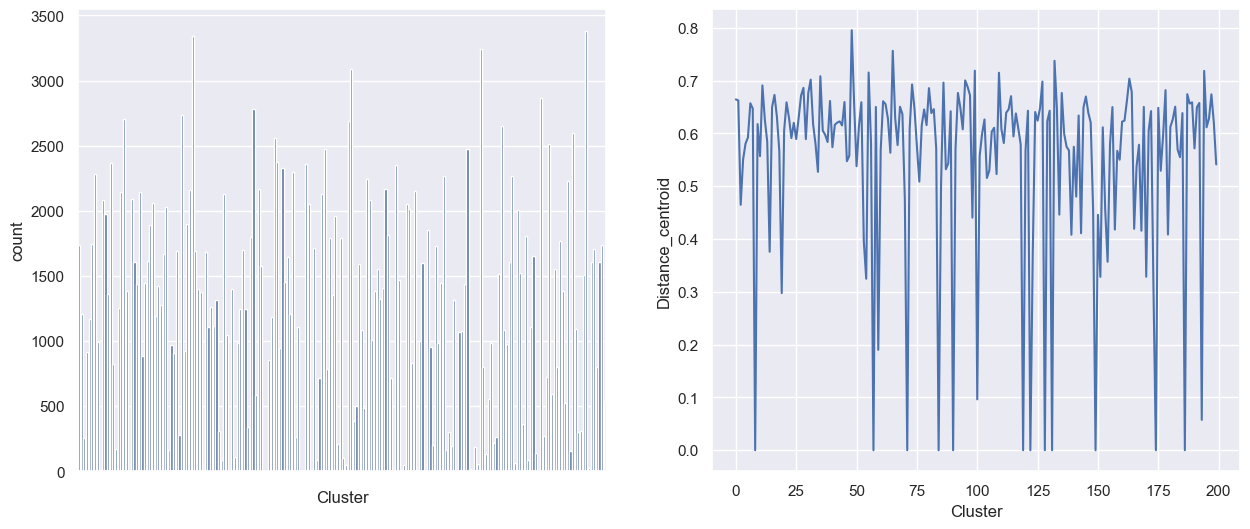

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

count = pos_comments_clusters["Cluster"].value_counts().reset_index()
sns.barplot(pos_comments_clusters["Cluster"].value_counts(), ax=ax1)
ax1.set_xticklabels([])

mean_dist = pos_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

preserved_clusters_pos = np.sort(pos_comments_clusters["Cluster"].unique())
centroids_pos = kmeans.cluster_centers_[preserved_clusters_pos]

#### Negative comments

In [45]:
embeds_neg = np.array(comments_embed_neg["Embedding"].tolist())

distortions_means = []
centroids_distances = []
nb_clusters = np.arange(50, 450, 50)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
    kmeans.fit(embeds_neg) 
    print("Clustering done")

    centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
    print(centers.shape)

    distances = np.linalg.norm(embeds_neg - centers, axis=1)
    print("Distances calculated")

    distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nb_clusters, distortions_means, marker='o')
ax1.set_title("Mean distortion")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean distortion")

ax2.plot(nb_clusters, centroids_distances, marker='o')
ax2.set_title("Mean distance between clusters")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

fig.suptitle("Clusters on negative comments")

400
Clustering done
(184609, 1024)
Distances calculated
350
Clustering done
(184609, 1024)
Distances calculated
300


KeyboardInterrupt: 

#### $250$ Clusters

In [42]:
kmeans = MiniBatchKMeans(n_clusters=250, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_neg)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_neg - centers, axis=1)

neg_comments_clusters = comments_embed_neg.assign(Cluster=kmeans.labels_, Distance_centroid=distances)
neg_comments_clusters

,Game id,User id,index,Phrases,Length,Embedding,Cluster,Distance_centroid
0,6179,0,0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",16,"[-0.0695, 0.00817, -0.0467, -0.0003633, -0.048...",105,0.632150
0,6179,0,0,Lorsque l'on a envie d'y rejouer encore pour e...,19,"[-0.037, 0.0311, -0.05243, 0.02927, -0.01709, ...",143,0.689857
0,6179,0,0,"Et lorsqu'en plus, au détour des règles, on s'...",63,"[-0.009766, 0.02106, -0.04266, 0.02167, -0.032...",103,0.626832
0,6179,0,0,"Ça, c'est deux fois bon !",6,"[-0.01927, 0.02855, -0.04385, 0.01256, -0.0122...",240,0.580998
2,6179,2,2,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ...",40,"[-0.007046, -0.01833, -0.02527, -0.00772, -0.0...",143,0.732569
...,...,...,...,...,...,...,...,...
96531,7155,3628,96531,"Assez plaisant, Pecking order fait partie des ...",10,"[-0.003836, -0.007484, -0.05325, 0.01438, -0.0...",239,0.659902
96532,7155,962,96532,"FLuide, donc, et rapide.",4,"[-0.03653, 0.05838, -0.04675, -0.03366, -0.024...",93,0.506359
96532,7155,962,96532,C'est la première impression que m'a donnée ce...,22,"[-0.0003912, 0.02957, -0.04504, 0.0197, -0.031...",246,0.547724
96532,7155,962,96532,Le bluff et la gestion de la pioche sont les p...,58,"[-0.04196, 0.002773, -0.03384, -0.006973, 0.00...",44,0.645420


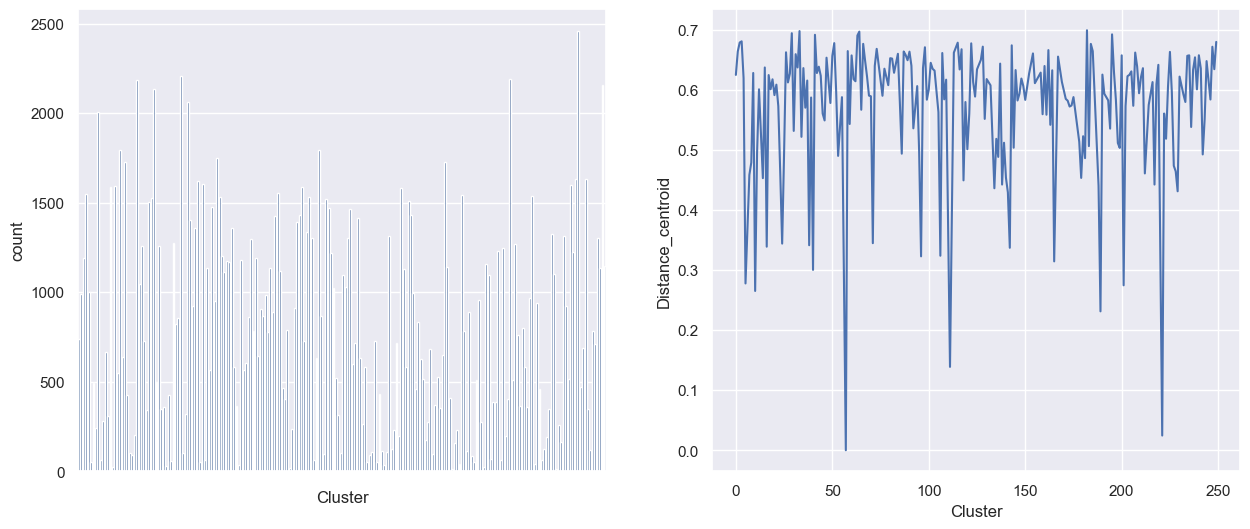

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

count = neg_comments_clusters["Cluster"].value_counts().reset_index()
sns.barplot(neg_comments_clusters["Cluster"].value_counts(), ax=ax1)
ax1.set_xticklabels([])

mean_dist = neg_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]
neg_comments_clusters

preserved_clusters_neg = np.sort(neg_comments_clusters["Cluster"].unique())
centroids_neg = kmeans.cluster_centers_[preserved_clusters_neg]

In [ ]:
distortions_means = []
centroids_distances = []
nb_clusters = np.arange(100, 1100, 100)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=1) 
    kmeans.fit(embeds) 
    print("Clustering done")

    centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
    print(centers.shape)

    distances = np.linalg.norm(embeds - centers, axis=1)
    print("Distances calculated")

    distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)


### $500$ clusters

In [8]:
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=1024, random_state=42, verbose=1) 
kmeans.fit(embeds) 

#centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
#distances = np.linalg.norm(embeds - centers, axis=1)

#comments_clusters = comments_embed.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

Init 1/1 with method k-means++
Inertia for init 1/1: 1857.654659123808
[MiniBatchKMeans] Reassigning 208 cluster centers.
Minibatch step 1/59756: mean batch inertia: 0.6011316722219989
Minibatch step 2/59756: mean batch inertia: 0.4642018405463928, ewa inertia: 0.4642018405463928
Minibatch step 3/59756: mean batch inertia: 0.4437273670324685, ewa inertia: 0.46413331435984756
Minibatch step 4/59756: mean batch inertia: 0.4423755176089371, ewa inertia: 0.4640604930080334
Minibatch step 5/59756: mean batch inertia: 0.427095716288578, ewa inertia: 0.4639367752878509
[MiniBatchKMeans] Reassigning 324 cluster centers.
Minibatch step 6/59756: mean batch inertia: 0.42087799139289095, ewa inertia: 0.46379266148411424
Minibatch step 7/59756: mean batch inertia: 0.4213397669179596, ewa inertia: 0.4636505755364367
Minibatch step 8/59756: mean batch inertia: 0.42644718727676256, ewa inertia: 0.4635260592052957
Minibatch step 9/59756: mean batch inertia: 0.41797310148151445, ewa inertia: 0.463373597

MiniBatchKMeans(n_clusters=500, random_state=42, verbose=1)

Text(0.5, 1.0, 'Number of phrases per cluster')

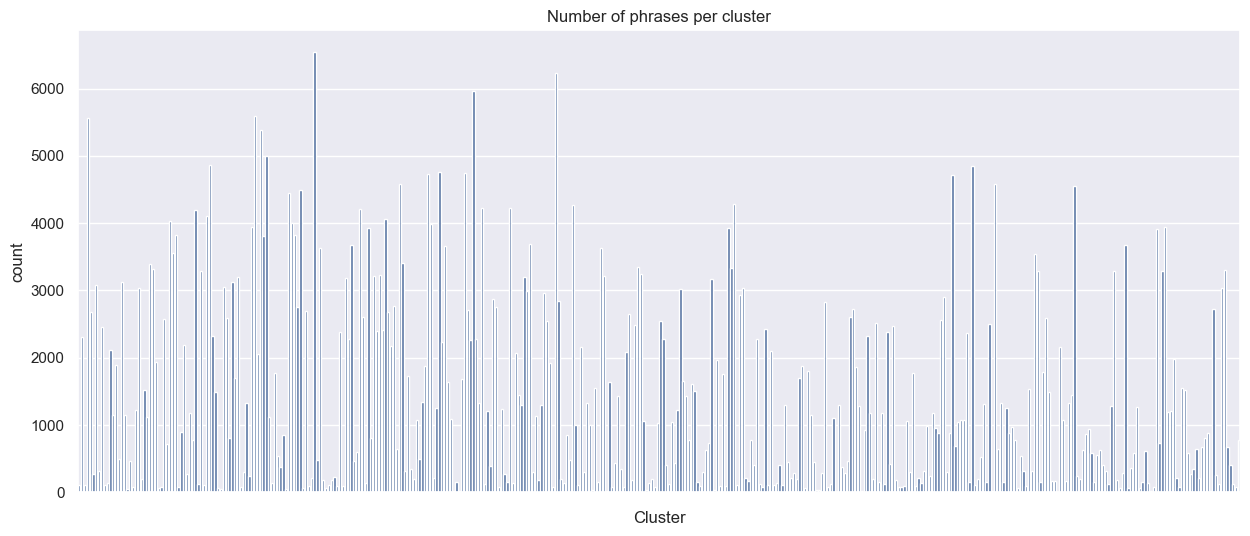

In [ ]:
sns.set_theme(rc={"figure.figsize":(15, 6)})
ax = sns.barplot(data=comments_clusters["Cluster"].value_counts().reset_index(), x="Cluster", y="count")
ax.set(xticklabels=[])
ax.set_title("Number of phrases per cluster")

### Discard clusters that have less than $10$ comments in them

In [21]:
count = comments_clusters["Cluster"].value_counts().reset_index()
clusters = count[count["count"] >= 10]["Cluster"]
comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(clusters)]
comments_clusters.shape

(585601, 8)

Text(0.5, 1.0, 'Mean intra-cluster distance')

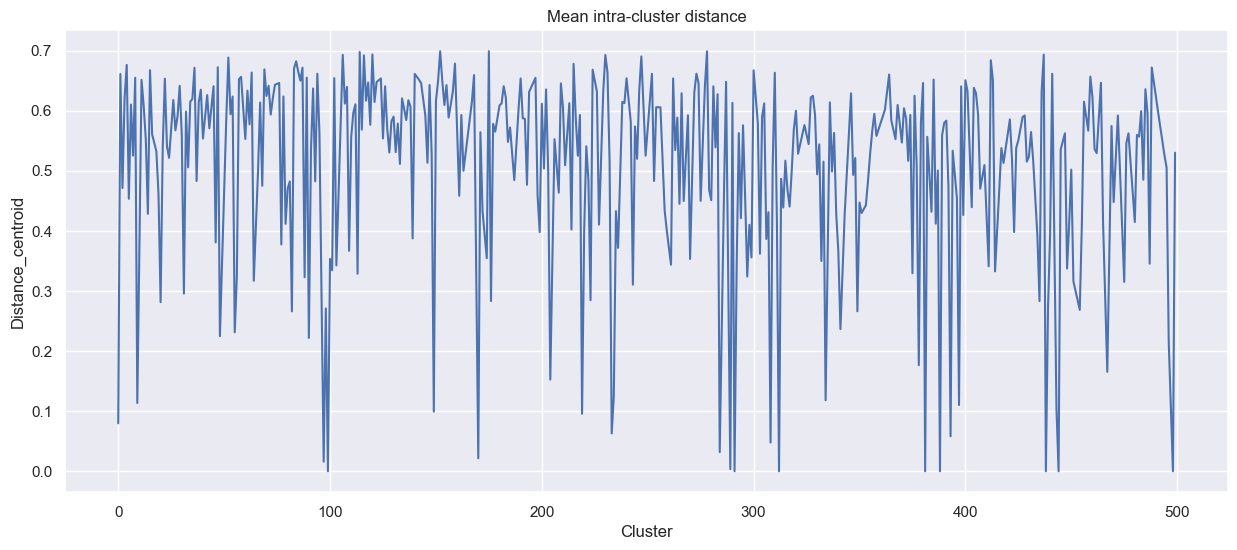

In [22]:
ax = sns.lineplot(comments_clusters.groupby("Cluster")["Distance_centroid"].mean())
ax.set_title("Mean intra-cluster distance")

### Discard clusters where mean inter-cluster distance > $0.7$

In [23]:
mean_dist = comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()

clusters = mean_dist[mean_dist["Distance_centroid"] > 0.70]["Cluster"]

print("Number of discarded comments:", count[count["Cluster"].isin(clusters)]["count"].sum())

comments_clusters = comments_clusters[~comments_clusters["Cluster"].isin(clusters)]

Number of discarded comments: 0


In [3]:
comments_clusters = pd.read_parquet("../generated_data/comments_clusters.parquet")
comments_clusters 

,Game id,User id,index,Phrases,Length,Embedding,Cluster,Distance_centroid
0,6179,0,0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",16,"[-0.0695, 0.00817, -0.0467, -0.0003633, -0.048...",127,0.624068
0,6179,0,0,Lorsque l'on a envie d'y rejouer encore pour e...,19,"[-0.037, 0.0311, -0.05243, 0.02927, -0.01709, ...",278,0.686084
0,6179,0,0,"Et lorsqu'en plus, au détour des règles, on s'...",63,"[-0.009766, 0.02106, -0.04266, 0.02167, -0.032...",63,0.622098
0,6179,0,0,"Ça, c'est deux fois bon !",6,"[-0.01927, 0.02855, -0.04385, 0.01256, -0.0122...",171,0.580657
1,6179,1,1,Simplement.,1,"[-0.03308, 0.0382, -0.0513, -0.01062, -0.0212,...",263,0.423417
...,...,...,...,...,...,...,...,...
142462,6025,3346,142462,un peu tout le temps la même chose.,8,"[-0.03111, 0.0636, -0.06042, -0.00909, -0.0026...",76,0.590910
142465,6025,4735,142465,"Je n'y ai joué qu'à deux joeurs, mais il se ré...",14,"[-0.0418, 0.02182, -0.0768, 0.01005, -0.03174,...",244,0.583143
142465,6025,4735,142465,Peut etre un peu trop de hasard au tirage des ...,23,"[-0.04053, 0.015564, -0.0446, -1.29e-05, -0.03...",111,0.548379
142465,6025,4735,142465,A voir sur une partie pour 8 joueurs,8,"[0.00842, -0.00392, -0.08704, 0.0337, -0.01195...",302,0.597711


### Generating comments pos/neg separation

In [49]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

In [55]:
def lemmatize_comment(phrases:pd.DataFrame, tagdir:str, lemmas:pd.DataFrame):
    tagger = TreeTagger(TAGDIR=tagdir, TAGLANG="fr")

    text = phrases["Phrases"]

    # Remove punctuation
    FR_stopwords = stopwords.words("french")
    FR_stopwords += ['donc', 'alors', 'que', 'qui', 'car', 'parce', 'ca']
    FR_stopwords.remove("ne")
    FR_stopwords.remove("pas")

    text = text.str.lower()
    # N' ... pas -> Ne pas
    text = text.str.replace("n'", "ne ")

    # Remove remaining punctuation
    punc_to_delete = punctuation
    punc_to_delete += "…•"
    trans_table = str.maketrans(punc_to_delete, " " * len(punc_to_delete))
    text = text.str.translate(trans_table)

    # Remove stopwords
    text = text.apply(lambda x: " ".join([word for word in x.split() if word not in FR_stopwords]))

    # Tokenization
    # text_df = text.to_frame().rename(columns={0: "Tokens"})
    words = pd.DataFrame({"Tokens": text.apply(word_tokenize), "Phrase line":text.index}).explode("Tokens")
    words["index"] = np.arange(0, words.shape[0])

    # Replace characters who which repeats 3 or more times
    words["Tokens"] = words["Tokens"].str.replace(r"(.)\1{2,}", r"\1", regex=True)

    # Remove Hashes (hex like words)
    words = words[~words["Tokens"].str.match(r"^(?=.*\d)[a-z0-9]{20,}$", na=False)]

    # Delete digits and words like 4eme, 10e
    words["Tokens"] = words["Tokens"].str.replace(r"\d+\w*", " ", regex=True)

    # Limit words lengths
    words["Len"] = words["Tokens"].str.len()
    words = words[(words["Len"] > 1) & (words["Len"] < 20)].drop(columns="Len")

    # Lemmatization
    tagger = TreeTagger(TAGDIR=tagdir, TAGLANG="fr")
    all_words = words["Tokens"].unique()

    lemmas_df = pd.DataFrame(data={"Lemma": tagger.tag_text(all_words)})

    # Split return value of TreeTagger into Token (word) | Part of Speech | Lemma
    lemmas_df = lemmas_df["Lemma"].str.split('\t', expand=True).set_axis(["Tokens", "POS", "Lemma"], axis=1)

    # Change 'ne' and 'pas' part of speech
    lemmas_df.loc[lemmas_df["Lemma"].isin(["ne", "pas"]), "POS"] = "NEG"

    # Strip accents
    lemmas_df.loc[:, "Lemma"] = lemmas_df["Lemma"].apply(unidecode)

    # Select lemmas in corpus
    lemmas_df = lemmas_df[lemmas_df["Lemma"].isin(lemmas["Lemma"])]
    return lemmas_df.merge(words, on="Tokens").sort_values(["Phrase line", "index"]).groupby("Phrase line")["Lemma"].apply(" ".join)

In [111]:
def eval_embeddings(user_id, matrix_ratings, mask_ratings, users_table, games_table, 
                    cos_dist_matrix, k, users_means, all_comments_clusters,
                    pos_comments_clusters, neg_comments_clusters, pos_preserved_clusters, neg_preserved_clusters,
                    pos_centroids, neg_centroids, comments_lemmatized, specific_game=None):
    
    MR, mask = matrix_ratings.tolil(), mask_ratings.tolil()

    user_ind = users_table[users_table == user_id].index.item()
    #games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)

    prev_ratings, prev_mask_ratings = MR[user_ind, :], mask[user_ind, :], 
    prev_sim = cos_dist_matrix[user_ind, :]

    if specific_game is None:
        hidden_games = hide_ratings(MR, mask, user_ind, 0.1)
    else:
        specific_game_ind = games_table[games_table == specific_game].index.item()
        hidden_games = np.array([specific_game_ind])
        MR[user_ind, specific_game_ind], mask[user_ind, specific_game_ind] = 0, 0

    print("Number of hidden games", hidden_games.size)
    recalc_cos_similarity(user_ind, MR, cos_dist_matrix)

    # choice of similar users
    sim_users =  get_KNN(cos_dist_matrix, k, user_ind)
    
    #print("similar users", sim_users, len(sim_users))
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(MR, mask,
                                                                sim_users, cos_dist_matrix, user_ind)
    
    # restore
    MR[user_ind, :], mask[user_ind, :] = prev_ratings, prev_mask_ratings
    cos_dist_matrix[user_ind, :], cos_dist_matrix[:, user_ind] = prev_sim, prev_sim

    diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

    ALLOW_ERR = 3

    user_mean = users_means.loc[users_means["User id"] == user_id, "Rating"].item()
    pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean
    
    correct_neg = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
    correct_pos = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

    # Find games ids
    pos_game_ids = games_table[games_table.index.isin(correct_pos)].values
    neg_game_ids = games_table[games_table.index.isin(correct_neg)].values

    # Find users ids
    sim_users_ids = users_table[users_table.index.isin(sim_users)].values

    
    # Treat positive ratings
    print(f"Correct predicted ratings neg : {neg_game_ids.size}, pos : {pos_game_ids.size} ({hidden_games.size} hidden)")

    if specific_game is not None:
        return find_phrases(user_id, specific_game, sim_users_ids, pos_game_ids,
                            all_comments_clusters, pos_comments_clusters,
                            pos_centroids, comments_lemmatized, pos_preserved_clusters, True)

    bigrams, unigrams = [], []
    for game in pos_game_ids:
        b, u = find_phrases(user_id, game, sim_users_ids, pos_game_ids,
                            all_comments_clusters, pos_comments_clusters,
                            pos_centroids, comments_lemmatized, pos_preserved_clusters)
        bigrams.append(b)
        unigrams.append(u)
    
    # Treat negative ratings
    for game in neg_game_ids:
        b, u = find_phrases(user_id, game, sim_users_ids, neg_game_ids,
                            all_comments_clusters, neg_comments_clusters,
                            neg_centroids, comments_lemmatized, neg_preserved_clusters)
        bigrams.append(b)
        unigrams.append(u)

    return bigrams, unigrams
    #return find_phrases(user_id, sim_users_ids, pos_game_ids, neg_game_ids, comments_clusters, centroids, comments_lemmatized)

def find_phrases(target_user_id, game_id, sim_users_ids, pred_games_ids, all_commments_clusters, comments_clusters, centroids, comments_lemmatized,
                 preserved_clusters, return_phrases=False):

    # Hide target user comment on the game
    comments_hidden = comments_clusters[(comments_clusters["User id"] != target_user_id ) | (~comments_clusters["Game id"].isin(pred_games_ids))]

    sim_users_comments = comments_clusters[comments_clusters["User id"].isin(sim_users_ids) & (comments_clusters["Game id"] == game_id)]
    
    # print("Number of similar users comments", sim_users_comments.size)
    # Place each similar user into the space
    sim_users_comments = sim_users_comments.groupby("User id")["Embedding"].mean().reset_index()

    if (sim_users_comments.empty):
       return np.nan, np.nan
    
    #print("similar users", sim_users_comments)
    # Embedding of the target user

    target_user_embed = sim_users_comments["Embedding"].mean()
    # Find closest clusters
    centers_dist = cdist(centroids, target_user_embed.reshape(1, -1)).flatten()

    nearest_clusters = preserved_clusters[np.argsort(centers_dist)][:5]
    #print("Distances",centers_dist[np.argsort(centers_dist)[:10]], nearest_clusters)

    sel_phrases = pd.DataFrame(data={"Phrases":[]})
    K = 15 # Select K phrases from each cluster

    for cluster in nearest_clusters:
        phrases_cluster = comments_hidden.loc[comments_hidden["Cluster"] == cluster, ["Phrases", "Embedding"]]
        phrases_embeds = np.array(phrases_cluster["Embedding"].tolist())

        dist = cdist(phrases_embeds, target_user_embed.reshape(1, -1)).flatten()
        # print(cluster, dist[np.argsort(dist)[:K]])
        phrases_dist = np.argsort(dist)[:K]

        sel_phrases = pd.concat([sel_phrases, phrases_cluster.iloc[phrases_dist]["Phrases"]])

    sel_phrases["Length"] = sel_phrases["Phrases"].str.split().apply(len)
    
    if return_phrases:
        return sel_phrases
    
    phrases_lemma = lemmatize_comment(sel_phrases, "/Users/bsh2022/Study/L3/Projet_recherche/TreeTagger", lemmas).reset_index()

    real_comment = comments_lemmatized[(comments_lemmatized["Game id"] == game_id) & (comments_lemmatized["User id"] == target_user_id)]["Lemma"].item()
    pred_phrases = " ".join(phrases_lemma["Lemma"])

    # Intersecting bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bigrams1 = set(vectorizer.fit([pred_phrases]).get_feature_names_out())
    bigrams2 = set(vectorizer.fit([real_comment]).get_feature_names_out())

    # Intersecting unigrams
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    unigrams1 = set(vectorizer.fit([pred_phrases]).get_feature_names_out())
    unigrams2 = set(vectorizer.fit([real_comment]).get_feature_names_out())

    print("Intersecting unigrams",  unigrams1 & unigrams2)
    print("Intersecting bigrams", bigrams1 & bigrams2)


    return len(bigrams1 & bigrams2), len(unigrams1 & unigrams2)


In [75]:
comments_clusters = pd.read_parquet("../generated_data/comments_clusters.parquet")
comments_clusters

,Game id,User id,index,Phrases,Length,Embedding,Cluster,Distance_centroid
0,6179,0,0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",16,"[-0.0695, 0.00817, -0.0467, -0.0003633, -0.048...",127,0.624068
0,6179,0,0,Lorsque l'on a envie d'y rejouer encore pour e...,19,"[-0.037, 0.0311, -0.05243, 0.02927, -0.01709, ...",278,0.686084
0,6179,0,0,"Et lorsqu'en plus, au détour des règles, on s'...",63,"[-0.009766, 0.02106, -0.04266, 0.02167, -0.032...",63,0.622098
0,6179,0,0,"Ça, c'est deux fois bon !",6,"[-0.01927, 0.02855, -0.04385, 0.01256, -0.0122...",171,0.580657
1,6179,1,1,Simplement.,1,"[-0.03308, 0.0382, -0.0513, -0.01062, -0.0212,...",263,0.423417
...,...,...,...,...,...,...,...,...
142462,6025,3346,142462,un peu tout le temps la même chose.,8,"[-0.03111, 0.0636, -0.06042, -0.00909, -0.0026...",76,0.590910
142465,6025,4735,142465,"Je n'y ai joué qu'à deux joeurs, mais il se ré...",14,"[-0.0418, 0.02182, -0.0768, 0.01005, -0.03174,...",244,0.583143
142465,6025,4735,142465,Peut etre un peu trop de hasard au tirage des ...,23,"[-0.04053, 0.015564, -0.0446, -1.29e-05, -0.03...",111,0.548379
142465,6025,4735,142465,A voir sur une partie pour 8 joueurs,8,"[0.00842, -0.00392, -0.08704, 0.0337, -0.01195...",302,0.597711


In [88]:
np.random.seed(1)
bigrams, unigrams = [], [] 
users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
for user in users:
    print(user)
    b, u = eval_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, users_means, comments_clusters, pos_comments_clusters, neg_comments_clusters, 
                           preserved_clusters_pos, preserved_clusters_neg, centroids_pos, centroids_neg, 
                           comments_lemmatized)
    bigrams.append(b)
    unigrams.append(u)
    print("-------------------------------")

1725
Number of hidden games 24
Correct predicted ratings neg : 12, pos : 8 (24 hidden)
Intersecting unigrams {'dire', 'aspect', 'illustration', 'bien', 'systeme', 'voir', 'tres', 'coup', 'coeur', 'tour', 'trouver', 'rester', 'beau', 'falloir', 'jeu', 'bluff', 'sympa', 'si', 'mettre', 'materiel', 'cela'}
Intersecting bigrams {'rester jeu', 'jeu tres', 'tres bien'}
Intersecting unigrams {'theme', 'jouer', 'ambiance', 'vrai', 'joueur', 'pas', 'rapide', 'fun', 'tres', 'rien', 'jeu', 'echange', 'etre'}
Intersecting bigrams set()
Intersecting unigrams {'rigolade', 'moment', 'joueur', 'passer', 'pas', 'rapide', 'fun', 'jeu'}
Intersecting bigrams {'passer moment', 'jeu fun'}
Intersecting unigrams {'theme', 'partie', 'joli', 'amuser', 'coller', 'bien', 'joueur', 'pas', 'tres', 'tour', 'jeu', 'ne', 'petit'}
Intersecting bigrams {'ne pas', 'jeu ne'}
Intersecting unigrams {'ressembler', 'bien', 'plaisir', 'pas', 'avoir', 'dur', 'coup', 'fois', 'etre', 'fin', 'gagner', 'beau', 'histoire', 'aller', 

Similar users phrases are taken from all existing phrases in general clusters (no pos, neg separation)

Text(0.5, 1.0, 'Clustering pos/neg separation')

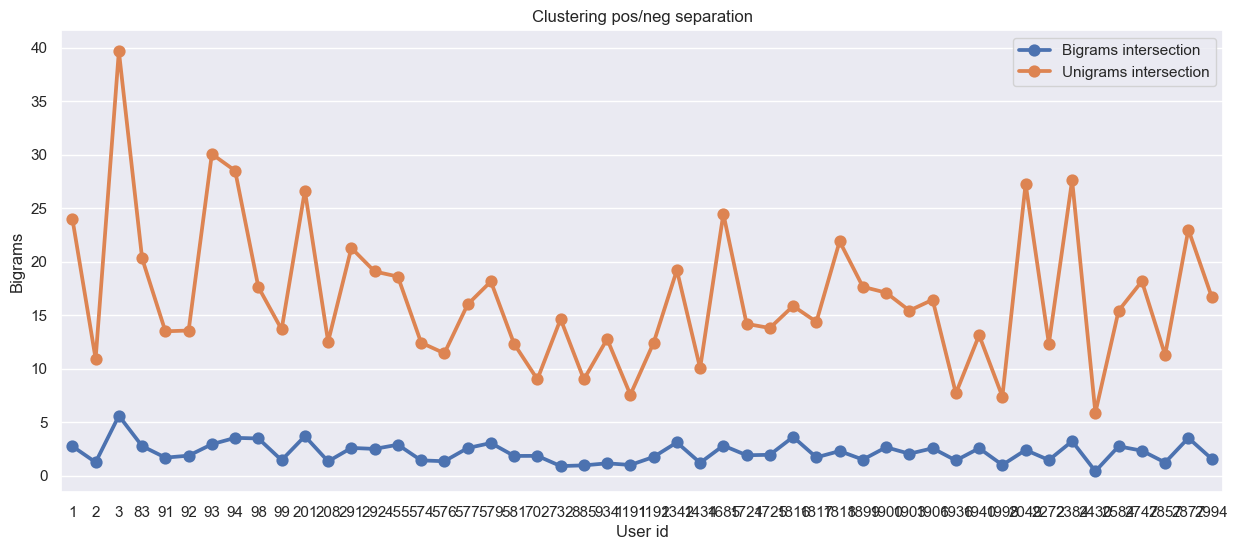

In [89]:
sns.set_theme(rc={"figure.figsize":(15, 6)})

data = pd.DataFrame(data={"User id":rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index,
                   "Bigrams":bigrams,
                   "Unigrams":unigrams})
data.loc[:, "Bigrams"] = data["Bigrams"].apply(np.nanmean)
data.loc[:, "Unigrams"] = data["Unigrams"].apply(np.nanmean)

ax = sns.pointplot(data=data, x="User id", y="Bigrams", label="Bigrams intersection")
sns.pointplot(data=data, x="User id", y="Unigrams", label="Unigrams intersection", ax=ax)

ax.set_title("Clustering pos/neg separation")

Similar users phrases are taken from pos (resp. neg) phrases in pos (resp. neg) clusters

In [ ]:
np.random.seed(1)
bigrams, unigrams = [], [] 
users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
for user in users:
    print(user)
    b, u = eval_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, users_means, pos_comments_clusters, neg_comments_clusters, 
                           preserved_clusters_pos, preserved_clusters_neg, centroids_pos, centroids_neg, 
                           comments_lemmatized)
    bigrams.append(b)
    unigrams.append(u)
    print("-------------------------------")

1725
Number of hidden games 24
Correct predicted ratings neg : 12, pos : 8 (24 hidden)
Number of similar users comments 56
Intersecting unigrams {'dire', 'aspect', 'illustration', 'bien', 'systeme', 'prix', 'stock', 'voir', 'tres', 'coup', 'boomerang', 'tour', 'trouver', 'rester', 'beau', 'falloir', 'adversaire', 'jeu', 'bluff', 'merci', 'efficace', 'sympa', 'si', 'mettre', 'rapport', 'materiel', 'cela'}
Intersecting bigrams {'beau jeu', 'rester jeu', 'jeu tres', 'tres bien', 'stock boomerang'}
Number of similar users comments 0
Number of similar users comments 232
Intersecting unigrams {'rigolade', 'redemander', 'moment', 'joueur', 'passer', 'rapide', 'fun', 'jeu'}
Intersecting bigrams set()
Number of similar users comments 0
Number of similar users comments 296
Intersecting unigrams {'bien', 'plaisir', 'pas', 'avoir', 'dur', 'coup', 'fois', 'etre', 'fin', 'gagner', 'beau', 'terminer', 'histoire', 'aller', 'public', 'jeu', 'impossible', 'partie', 'carte', 'vrai', 'joueur', 'strategie'

Text(0.5, 1.0, 'Clustering pos/neg separation')

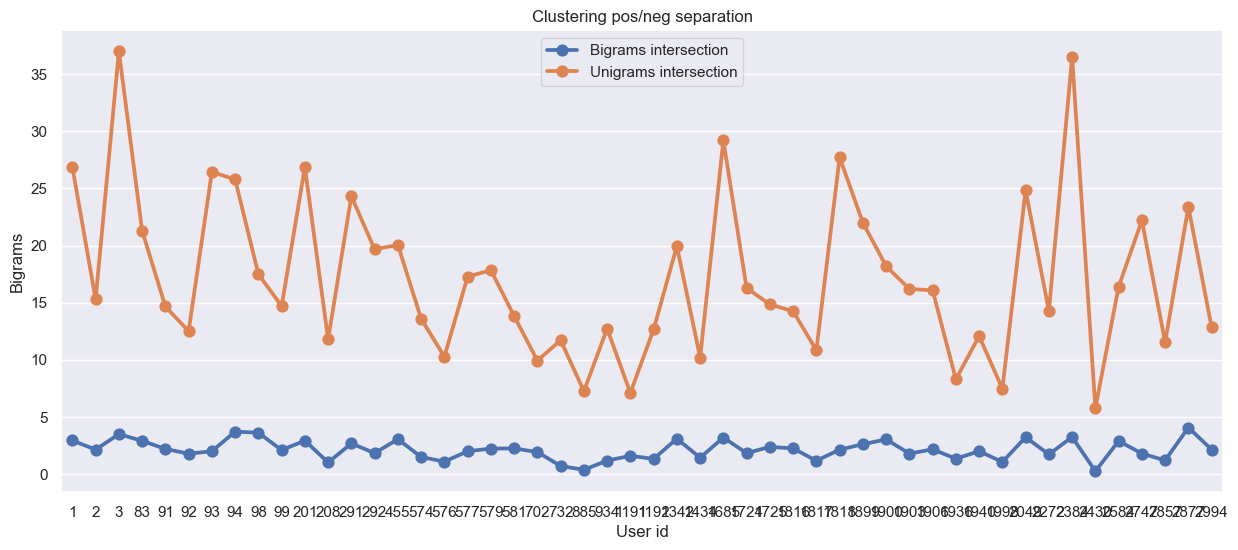

In [73]:
sns.set_theme(rc={"figure.figsize":(15, 6)})

data = pd.DataFrame(data={"User id":rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index,
                   "Bigrams":bigrams,
                   "Unigrams":unigrams})
data.loc[:, "Bigrams"] = data["Bigrams"].apply(np.nanmean)
data.loc[:, "Unigrams"] = data["Unigrams"].apply(np.nanmean)

ax = sns.pointplot(data=data, x="User id", y="Bigrams", label="Bigrams intersection")
sns.pointplot(data=data, x="User id", y="Unigrams", label="Unigrams intersection", ax=ax)

ax.set_title("Clustering pos/neg separation")

In [71]:
np.sort(rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index)

array([   1,    2,    3,   83,   91,   92,   93,   94,   98,   99,  201,
        208,  291,  292,  455,  574,  576,  577,  579,  581,  702,  732,
        885,  934, 1191, 1192, 1342, 1434, 1685, 1724, 1725, 1816, 1817,
       1818, 1899, 1900, 1903, 1906, 1936, 1940, 1998, 2049, 2272, 2384,
       2430, 2584, 2747, 2857, 2877, 2994])

Text(0.5, 1.0, 'Clustering without pos/neg separation')

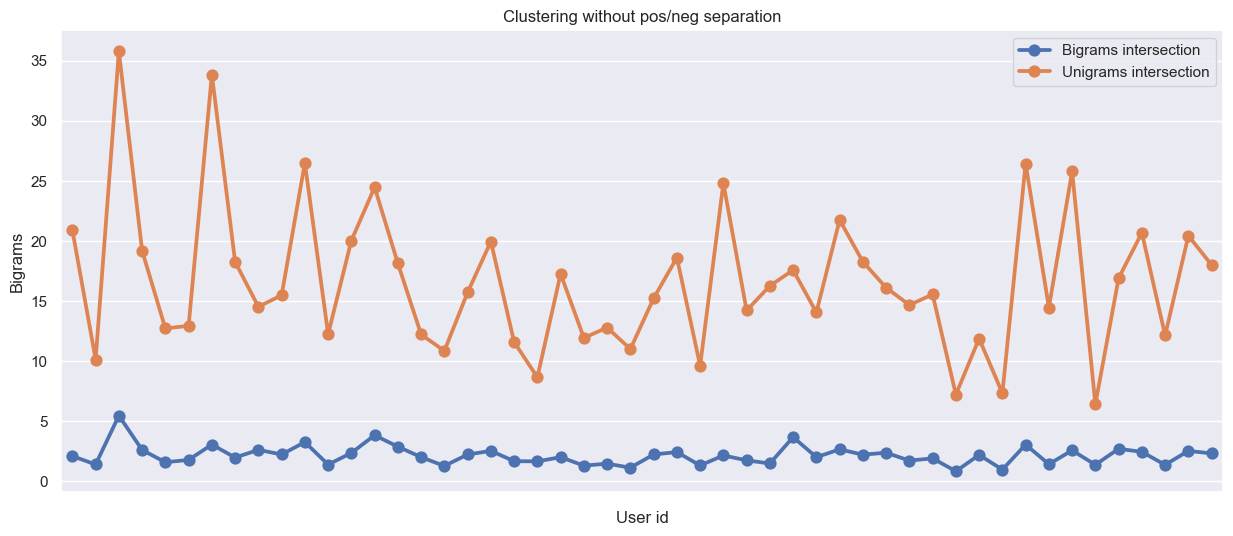

In [285]:
sns.set_theme(rc={"figure.figsize":(15, 6)})

data = pd.DataFrame(data={"User id":rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index,
                   "Bigrams":bigrams,
                   "Unigrams":unigrams})
data.loc[:, "Bigrams"] = data["Bigrams"].apply(np.nanmean)
data.loc[:, "Unigrams"] = data["Unigrams"].apply(np.nanmean)

ax = sns.pointplot(data=data, x="User id", y="Bigrams", label="Bigrams intersection")
sns.pointplot(data=data, x="User id", y="Unigrams", label="Unigrams intersection", ax=ax)

ax.set_xticklabels([])
ax.set_title("Clustering without pos/neg separation")

#### Combine selected phrases with LLM to generate natural comment

In [116]:
count = rev_filter.groupby("User id")["Rating"].count()
count[(count < 200) & (count > 100)], rev_filter[rev_filter["User id"] == 3670]["Game id"].unique()

(User id
 7       142
 18      109
 20      129
 43      151
 54      142
        ... 
 3077    109
 3428    176
 3670    118
 3672    121
 3836    123
 Name: Rating, Length: 166, dtype: int64,
 array([ 9316,  8092,   908,  8984,  5201,  8591,  8197,  9263,  7852,
         2921,  6269,  6369,  2582,  1410,  1302,  5919,  7244, 10474,
         5187,  5144,  6281,  6809,  1789,   102,  4943,  8924,  3595,
         5548,  1355,  7815,  6906,  3780,  1825,  9675,  8109,  9767,
         2561,  9566,  6126,  4354,  4360,  6184,  1865,  4308,  9389,
         8349,  9731,  6280,  7805,  8717,  1476,  8727,  7033,   277,
         3303,  5926,  6843,    65,  5553,  8269,  4768,  6325,  3831,
         5754,  5711,  9404,  3560,   927,  3564,  4351,  5397,  1608,
         5723,  4600,  4311,  4265,  7186, 10346,  5612,  9289,  4654,
         3985,  2720,  6507,  1219,  2099,  6114,  9066,  1271,  5586,
         2342,  4795,  8555,  6776,  4972,   801,  5210,  6351,   769,
         8316,  1108,  53

#### Generated comment

In [ ]:
user, game = 3670, 9316
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                50, users_means, comments_clusters, pos_comments_clusters, neg_comments_clusters,
                                preserved_clusters_pos, preserved_clusters_neg, centroids_pos, 
                                centroids_neg, comments_lemmatized, game).drop_duplicates()

print(phrases)
phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()

response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Number of hidden games 1
Correct predicted ratings neg : 1, pos : 0 (1 hidden)
                                                 Phrases  Length
54310  Jeu sympa en apparence, nécessite de la réflex...      12
57210   C'est un bon jeu où il faudra être opportuniste.       9
53132  Un jeu dans lequel il faut réfléchir vite et b...      10
64178          Un jeu où il faut avoir de la persuasion.       9
72707          Ce jeu nécessite un peu de concentration.       7
...                                                  ...     ...
1645   Il y a des surprises, de la tactique et du has...      14
1686   Le jeu est tout de même tactique, mais il y a ...      18
36628                               Le jeu est tactique.       4
90728  En fait, il y a plein de stratégies à mettre e...      18
57286  Beaucoup de chance dans ce jeu mais aussi un p...      18

[75 rows x 2 columns]
1
Nb tokens: 1524
Voici une possible rédaction d'un commentaire sur un jeu de plateau :

"Je l'ai essayé, et j'ai été 

#### Real comment

In [117]:
user, game = 3670, 9316

print(textwrap.fill(rev_filter[(rev_filter["Game id"] == game) & (rev_filter["User id"] == user)]["Comment body"].item(), width=100))

Attention, ce jeu est dangereusement addictif.Les règles sont légèrement complexes, mais rien
d'insurmontable. Je vous conseille dans un premier temps de télécharger les règles corrigées sur le
site de Bruno Faidutti car dans la version actuelle, elles sont parsemées d'erreurs et d'incohérence
; ce qui pour un jeu dont les mécanismes sont un peu plus complexes que les petits chevaux est très
gênant !Ce que j'apprécie particulièrement dans les différents mécanismes sont les conflits sur deux
niveaux :- les conflits internes que l'on peut comparer à une révolution ;- les conflits externes
engendrés par la fusion de plusieurs royaumes.Toute la subtilité du jeu consiste à développer son
royaume pour éventuellement absorber les royaumes adversaires en évitant les déséquilibres qui
risqueraient de provoquer des rebellions.Les stratégies sont diverses et je n'ai pas pour le moment
réussi à trouver des techniques qui sans garantir une victoire finale permettraient d'éviter les
conflits interne